### Przygotowanie danych

Naszym pierwszym zadaniem jest przygotowanie wsadu dla modeli uczenia maszynowego. Zrobimy to przy wykorzystaniu `numpy`, `pandas` i `rasterio`, generując szybko ramkę danych z kolumnami `NDVI`, `NDWI`, `SCI` i kolumną `y`, która reprezentować będzie dane binarne: **to, czy dany piksel jest terenem zabudowanym, czy nie jest**.

In [1]:
import numpy as np
import pandas as pd
import rasterio as rio

from keras.models import Sequential
from keras.layers import Dense

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
import matplotlib.pyplot as plt

from bands.load import LoadBandsFromTif

2022-12-08 09:24:21.533970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 09:24:21.704452: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 09:24:21.704470: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-08 09:24:22.667425: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
BINARY_DATA = './results/clc_results/binarized_clc.tif'
NDVI_DATA = './results/ndvi.tif'
NDWI_DATA = './results/ndwi.tif'
SCI_DATA = './results/sci.tif'

Teraz ułożymy wartości do ramki danych, najpierw wczytamy wszystkie dane:

In [3]:
bin_band = LoadBandsFromTif(BINARY_DATA).get_band()
ndv_band = LoadBandsFromTif(NDVI_DATA).get_band()
ndw_band = LoadBandsFromTif(NDWI_DATA).get_band()
sci_band = LoadBandsFromTif(SCI_DATA).get_band()

Teraz utworzymy ramkę danych... najpierw wszystkie wartości:

In [4]:
arr = np.empty(shape=(len(bin_band.flatten()), 4))
arr.shape

(4445532, 4)

In [5]:
arr[:, 0] = bin_band.flatten()
arr[:, 1] = ndv_band.flatten()
arr[:, 2] = ndw_band.flatten()
arr[:, 3] = sci_band.flatten()

In [6]:
columns = ['y', 'ndvi', 'ndwi', 'sci']
df = pd.DataFrame(data=arr, columns=columns)
df.head()

,y,ndvi,ndwi,sci
0,0.0,0.861824,-0.827907,0.827907
1,0.0,0.857498,-0.818329,0.818329
2,0.0,0.857490,-0.826433,0.826433
3,0.0,0.868816,-0.825994,0.825994
4,0.0,0.865950,-0.835684,0.835684


Wczytamy podstawowe informacje o danych:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4445532 entries, 0 to 4445531
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   y       float64
 1   ndvi    float64
 2   ndwi    float64
 3   sci     float64
dtypes: float64(4)
memory usage: 135.7 MB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
y,4445532.0,0.586137,0.492525,0.000000,0.000000,1.000000,1.000000,1.000000
ndvi,4445532.0,0.519922,0.254621,-0.740552,0.307663,0.571663,0.751201,1.000000
ndwi,4445532.0,-0.557063,0.207317,-1.000000,-0.727110,-0.611056,-0.411924,0.715823
sci,4445532.0,0.557063,0.207317,-0.715823,0.411924,0.611056,0.727110,1.000000


Dane wyglądają na prawidłowe.
Zapiszemy dataframe do pliku csv:

In [9]:
df.to_csv('./results/prepared_frame.csv')

Ponieważ powyższy plik csv jest bardzo duży nie dodałam go do repozytorium, dostępny jest pod linkiem: https://drive.google.com/file/d/19j4ZU3wLrPNlQbX7DQIPrINN6MxAnUC9/view?usp=share_link

### Transformacja danych wejściowych i podział na zbiór treningowy i testowy.

W tym kroku przygotowujemy dane jako wsad do modeli uczenia maszynowego. Jako że wskaźniki są już w przedziale -1 do 1, możemy tylko podzielić dane na zbiór treningowy i testowy. Wykorzystamy do tego możliwości, jakie daje pakiet `scikit-learn`.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop('y', axis=1),
    df['y'],
    random_state=14)

In [11]:
print(x_train.describe().T)
print("------------------------------------------------------------------------------")
print(x_test.describe().T)

          count      mean       std       min       25%       50%       75%  \
ndvi  3334149.0  0.519918  0.254616 -0.740552  0.307630  0.571672  0.751152   
ndwi  3334149.0 -0.557048  0.207348 -1.000000 -0.727063 -0.611058 -0.411840   
sci   3334149.0  0.557048  0.207348 -0.715823  0.411840  0.611058  0.727063   

           max  
ndvi  1.000000  
ndwi  0.715823  
sci   1.000000  
------------------------------------------------------------------------------
          count      mean       std       min       25%       50%       75%  \
ndvi  1111383.0  0.519933  0.254637 -0.667292  0.307802  0.571625  0.751345   
ndwi  1111383.0 -0.557110  0.207225 -1.000000 -0.727244 -0.611053 -0.412178   
sci   1111383.0  0.557110  0.207225 -0.626313  0.412178  0.611053  0.727244   

           max  
ndvi  1.000000  
ndwi  0.626313  
sci   1.000000  


In [12]:
print("Zbiór y trening liczy", y_train.count(), "elementów.")
print("Zbiór y testowy liczy", y_test.count(), "elementów.")

Zbiór y trening liczy 3334149 elementów.
Zbiór y testowy liczy 1111383 elementów.


### Trening różnych klasyfikatorów dostępnych w pakiecie scikit-learn.

Najpierw przeprowadzimy trening różnych klasyfikatorów dostępnych w pakiecie scikit-learn. Spośród nich wybierzemy:

> I. Drzewa decyzyjne,

> II. Lasy losowe,

> III. Naiwny Bayesowski klasyfikator,

> IV. Ada Boost,

> V. prostą sieć neuronową.


In [31]:
# Drzewa decyzyjne

decision_tree_classifier = DecisionTreeClassifier(criterion='gini', 
                                                  max_depth=10, 
                                                  min_samples_split=3, 
                                                  random_state=14)

decision_tree_classifier.fit(x_train, y_train)

# Predykcje

decision_tree_predictions = decision_tree_classifier.predict(x_test)

In [32]:
# Lasy losowe

random_forest_classifier = RandomForestClassifier(n_estimators=20,
                                                  max_depth=10,
                                                  n_jobs=-1)
random_forest_classifier.fit(x_train, y_train)
predictions_random_forest = random_forest_classifier.predict(x_test)

In [15]:
# Naive Bayes

nb_classifier = GaussianNB()
nb_classifier.fit(x_train, y_train)
predictions_bayes = nb_classifier.predict(x_test)

In [36]:
# Ada Boost

adaboost_classifier = AdaBoostClassifier(n_estimators=20)
adaboost_classifier.fit(x_train, y_train)
predictions_ada = adaboost_classifier.predict(x_test)

In [38]:
# Sieć neuronowa

nn_classifier = MLPClassifier(hidden_layer_sizes=(16, 16, 8, 2),
                              max_iter=30,
                              n_iter_no_change=5)
nn_classifier.fit(x_train, y_train)
predictions_nn = nn_classifier.predict(x_test)

### Trening klasyfikatora opartego na uczeniu głębokim przy wykorzystaniu pakietu Keras.

W tym momencie moglibyśmy już przerwać nasz trening i przejść do analizy wyników. Jednak dla porównania zastosujemy również sieć neuronową opartą na pakiecie `keras` i module `Tensorflow`. Taką sieć buduje się nieco inaczej niż tę z pakietu `scikit-learn`.

Do trenowania sieci neuronowej opartej na uczeniu głębokim potrzebować będziemy również zbioru walidacyjnego, dlatego podzielimy jeszcze nasz zbiór treningowy na dwie części: 1/5 zbioru zostanie odłożona do walidacji trenowanego modelu.

In [13]:
kmodel = Sequential()

2022-12-08 09:25:51.243948: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-08 09:25:51.244148: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-08 09:25:51.244176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (marta-websensa): /proc/driver/nvidia/version does not exist
2022-12-08 09:25:51.244837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
kmodel.add(Dense(16, activation='relu'))
kmodel.add(Dense(16, activation='relu'))
kmodel.add(Dense(8, activation='relu'))
kmodel.add(Dense(2, activation='relu'))
kmodel.add(Dense(1, activation='sigmoid'))

In [15]:
kmodel.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
len(x_train)

3334149

In [17]:
val_size = int(0.2 * len(x_train))

In [18]:
x_val = x_train[:val_size]
x_train_kmodel = x_train[val_size:]

y_val = y_train[:val_size]
y_train_kmodel = y_train[val_size:]

/tmp/ipykernel_4258/2640157673.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_val = y_train[:val_size]
/tmp/ipykernel_4258/2640157673.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train_kmodel = y_train[val_size:]


In [19]:
history = kmodel.fit(x_train_kmodel, y_train_kmodel,
                     epochs=10, batch_size=2048,
                     validation_data=(x_val, y_val))

Epoch 1/10
1303/1303 [==============================] - 4s 2ms/step - loss: 0.6147 - accuracy: 0.6938 - val_loss: 0.5963 - val_accuracy: 0.6988
Epoch 2/10
1303/1303 [==============================] - 3s 2ms/step - loss: 0.5929 - accuracy: 0.7031 - val_loss: 0.5928 - val_accuracy: 0.7037
Epoch 3/10
1303/1303 [==============================] - 3s 2ms/step - loss: 0.5928 - accuracy: 0.7031 - val_loss: 0.5932 - val_accuracy: 0.7041
Epoch 4/10
1303/1303 [==============================] - 3s 2ms/step - loss: 0.5926 - accuracy: 0.7033 - val_loss: 0.5932 - val_accuracy: 0.7040
Epoch 5/10
1303/1303 [==============================] - 3s 2ms/step - loss: 0.5923 - accuracy: 0.7035 - val_loss: 0.5935 - val_accuracy: 0.7045
Epoch 6/10
1303/1303 [==============================] - 3s 2ms/step - loss: 0.5919 - accuracy: 0.7039 - val_loss: 0.5916 - val_accuracy: 0.7032
Epoch 7/10
1303/1303 [==============================] - 3s 2ms/step - loss: 0.5914 - accuracy: 0.7044 - val_loss: 0.5911 - val_accuracy:

Po wytrenowaniu modelu sprawdźmy stratę trenowania i walidacji oraz dokładność trenowania i walidacji, by przekonać się, czy nie wystąpiło zjawisko przewymiarowania.

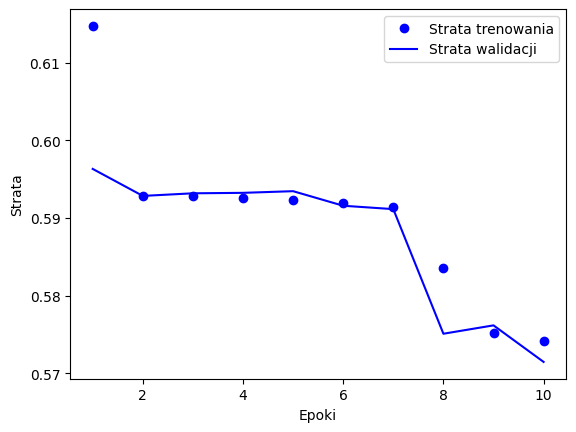

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')

plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

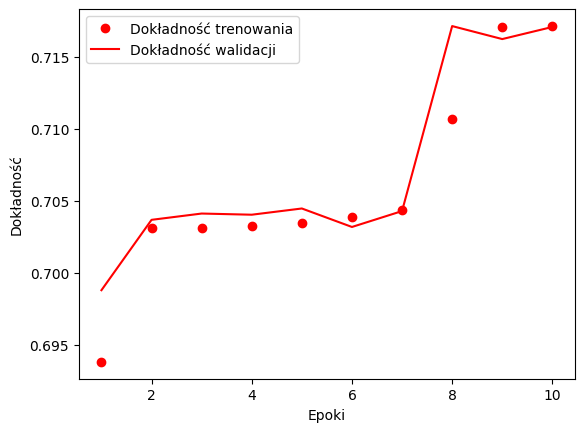

In [21]:
plt.plot(epochs, acc, 'ro', label='Dokładność trenowania')
plt.plot(epochs, val_acc, 'r', label='Dokładność walidacji')

plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

W tym wypadku dane nie są przewymiarowe, więc możemy dokonać predykcji.

In [22]:
predicted_keras = kmodel.predict(x_test, batch_size=2048)
predicted_keras[predicted_keras > 0.5] = 1
predicted_keras[predicted_keras <= 0.5] = 0

543/543 [==============================] - 1s 1ms/step


### Zestawienie wyników poszczególnych modeli.

Jak sprawują się poszczególne modele? Możemy to zbadać wykorzystując w tym celu macierze błędów i inne metryki opracowane dla klasyfikatorów. Funkcje, które je obliczają, dostępne są w pakiecie `scikit-learn`.

In [23]:
def show_predicted_output(predictions, y_t):
    
    output = accuracy_score(y_t, predictions)
    confusion = confusion_matrix(y_t, predictions, normalize='true')
    print(confusion_matrix)
    
    sns.heatmap(confusion, annot=True, cmap='Greens')

    print('Accuracy score is:', output)
    p_r_f1 = precision_recall_fscore_support(y_t, predictions, average='macro')
    print('Precision: {}, Recall: {}, F1 score: {}'.format(p_r_f1[0], p_r_f1[1], p_r_f1[2]))

<function confusion_matrix at 0x7f9465a5e290>
Accuracy score is: 0.7176724855427877
Precision: 0.7172959186093213, Recall: 0.6891181243900983, F1 score: 0.6928759302557961


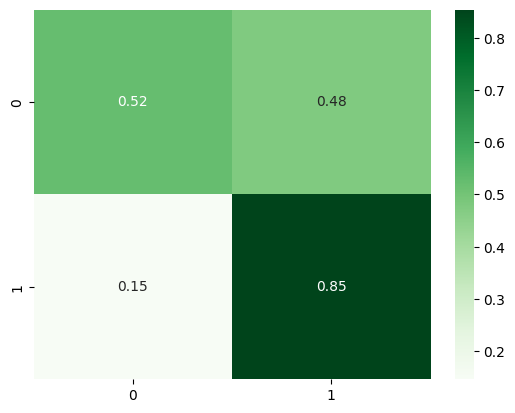

In [45]:
# Drzewa decyzyjne

show_predicted_output(decision_tree_predictions, y_test)

<function confusion_matrix at 0x7f9465a5e290>
Accuracy score is: 0.7170750317397333
Precision: 0.7178681871026058, Recall: 0.6874035351363217, F1 score: 0.691040227320729


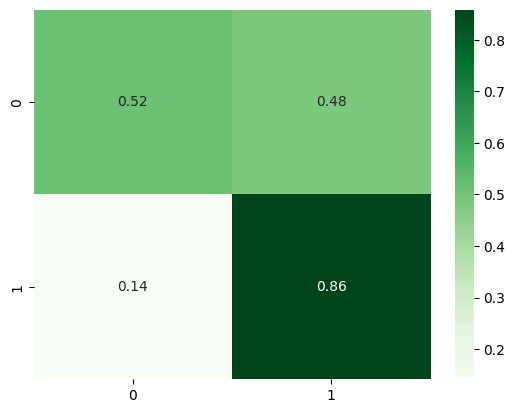

In [46]:
# Lasy Losowe

show_predicted_output(predictions_random_forest, y_test)

<function confusion_matrix at 0x7f9465a5e290>
Accuracy score is: 0.6620498963903533
Precision: 0.6594718391856411, Recall: 0.664256773138221, F1 score: 0.6584603197612633


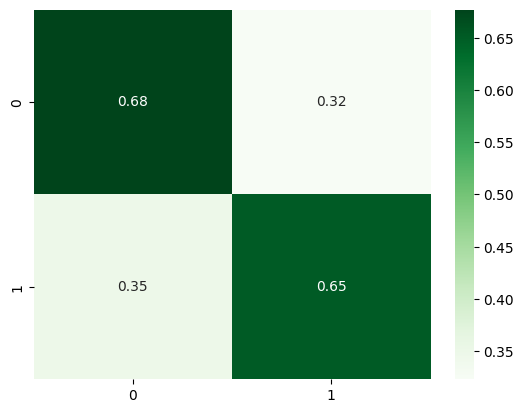

In [47]:
# Bayes

show_predicted_output(predictions_bayes, y_test)

<function confusion_matrix at 0x7f9465a5e290>
Accuracy score is: 0.7142776162672994
Precision: 0.7167898124087255, Recall: 0.6827162699596412, F1 score: 0.6859434623226246


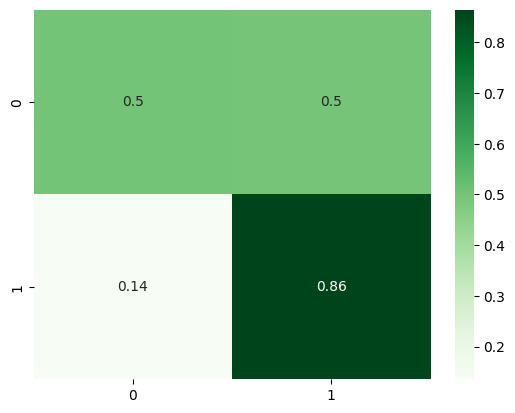

In [48]:
# ADA

show_predicted_output(predictions_ada, y_test)

<function confusion_matrix at 0x7f9465a5e290>
Accuracy score is: 0.7183068303186211
Precision: 0.7128579999227698, Recall: 0.6955743034653462, F1 score: 0.6992526785423694


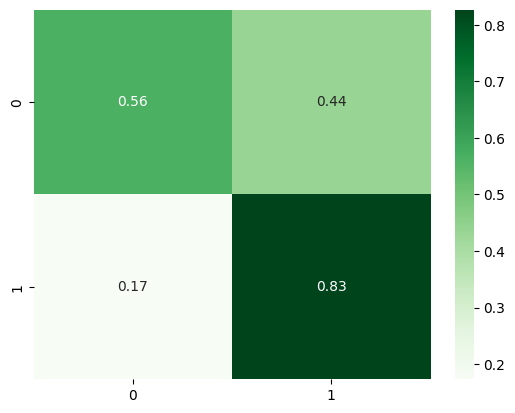

In [49]:
# Sieci Neuronowe = scikit

show_predicted_output(predictions_nn, y_test)

<function confusion_matrix at 0x7fd937fe5480>
Accuracy score is: 0.7171479139054673
Precision: 0.7141303331973544, Recall: 0.691094259500867, F1 score: 0.6948937171892664


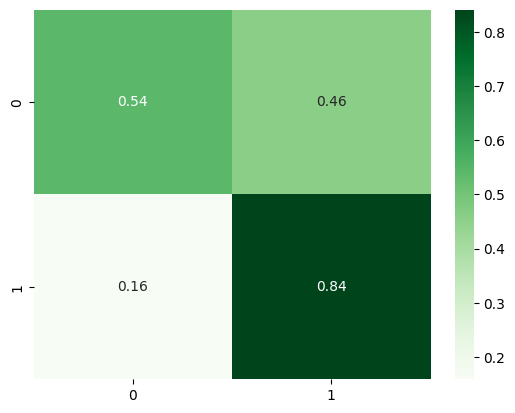

In [24]:
# Keras

show_predicted_output(predicted_keras, y_test)